In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

In [2]:
#load data
xs=pd.read_csv('HMP2_OnePerSubject.Genus.txt', sep="\t", index_col=0)
metx=pd.read_csv('HMP2_OnePerSubject.log10Metabs.txt', sep="\t", index_col=0)

#replace NaNs with median 
for i in metx.columns:
    med=metx[i].median()
    metx.loc[:,i]=metx.loc[:,i].fillna(med)

In [3]:
#zscore metadata: required for PCA-type matrix factorization
nSamp, nMet = metx.shape
nD=xs.shape[1]

In [4]:
def train_tmi(xs, metz, nQ, nC, nM, alph, ctf):
    nSamp, nO = xs.shape;
    nMet = metz.shape[1];
    nTot                = nQ + nC + nM;
    Z                   = 0.1*np.random.randn(nSamp,nTot);
    C                   = 0.1*np.random.randn(nTot,nMet);
    C[0:nQ,:]           = 0;
    thet                = 0.1*np.random.randn(nTot,nO);
    thet[nQ+nC:,:]      = 0;
    thetp               = thet.transpose();
    # hyperparameters
    etaZ = 0.001;etaT = 0.001;etaC = 0.001;
    Q = np.exp(np.matmul(-Z,thet));
    Q=np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
    m = 1;
    iteration = 1;
    while m > ctf:
        Q = np.exp(np.matmul(-Z,thet));
        Q=np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
        delt = xs.values-Q;
        # gradients
        grthet           = (alph)*np.matmul(Z.transpose(),delt);
        grthet[nQ+nC:,:] = 0;
        grzQ             = (alph)*np.matmul(delt,thetp);
        grzM             = -2*(1-alph)*np.matmul((metz.values-np.matmul(Z,C)),C.transpose());
        grz              = grzQ + grzM
        grc              = -2*(1-alph)*np.matmul(Z.transpose(),(metz.values - np.matmul(Z,C)))
        grc[0:nQ,:]      = 0;
        # update the variables
        Z     = Z - etaZ*grz
        thet  = thet - etaT*grthet
        C     = C - etaC*grc
        thetp = thet.transpose();
        
        # errors
        dmet=np.matmul(Z,C)-metz.values
        kl=np.nansum(xs.values*np.log(xs.values/Q))
        er=(dmet*dmet).sum()
        error=(1-alph)*kl + alph*er
        #m = np.min(np.min(Q));
        m=np.linalg.norm(grz)/np.linalg.norm(Z) + np.linalg.norm(grthet)/np.linalg.norm(thet)+np.linalg.norm(grc)/np.linalg.norm(C)
        # Output
        if np.mod(iteration,5000) == 0:
            print(m)
        iteration+=1
        
    return Z, C, thet, error

In [5]:
seed=18567
np.random.seed(seed)

In [6]:
# optimization parameters
nQ = 2;nC = 18;nM = 0;
ctf  = 1e-20; 
alph = 0.1; 
gctf = 0.01;

In [7]:
#first train model on all data
train=xs        ##
trainmet=metx   ##
test=xs
testmet=metx
N=len(train.index)

In [8]:
mu_met = trainmet.mean();sg_met = trainmet.std();
trainmetz=trainmet.subtract(mu_met).divide(sg_met)
testmetz=testmet.subtract(mu_met).divide(sg_met)

In [9]:
# Train model
Z, C, thet, error= train_tmi(train,trainmetz,nQ,nC,nM,alph,gctf);

/tmp/ipykernel_11875/3940590118.py:37: RuntimeWarning: divide by zero encountered in log
  kl=np.nansum(xs.values*np.log(xs.values/Q))
/tmp/ipykernel_11875/3940590118.py:37: RuntimeWarning: invalid value encountered in multiply
  kl=np.nansum(xs.values*np.log(xs.values/Q))


0.2430639589714353
0.07731718929273589
0.04611852446233172
0.03354908386298375
0.026352842387244724
0.021985532413274427
0.01857189338203135
0.015440526751126723
0.012978119480971377
0.011194285956005197


In [10]:
model={}
Q=np.exp(np.matmul(-Z,thet));
Q=np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
model['Z']=Z
model['thet']=thet
model['Q']=Q
model['xs']=train
model['C']=C
model['metz']=trainmetz
model['alph']=alph
model['nQ']=nQ
model['nC']=nC
model['nM']=nM
model['nD']=nD
model['seed']=seed
model['error']=error
model['test']=test
model['testmetz']=testmetz

In [11]:
filen = 'HMP2_'+str(nC)+'_'+str(nQ)+'_'+str(nM)+'_'+str(seed)+'_'+f'{error:.3}'+'.pickle'
filen

'HMP2_18_2_0_18567_6.64e+02.pickle'

In [12]:
#save model
with open(filen,'wb') as f:
        pickle.dump(model,f)

In [13]:
#############split dataset in 80% training, 20% testing
np.random.seed(seed)
N=int(nSamp*.2)
order=np.random.permutation(xs.index)
testids=order[0:N]

test=xs.loc[testids]
train=xs.loc[~xs.index.isin(testids)]
testmet=metx.loc[testids]
trainmet=metx.loc[~xs.index.isin(testids)]

N=len(train.index)

print('Test:')
print(test.shape)
print('Train:')
print(train.shape)
print('Testmet:')
print(testmet.shape)
print('Trainmet:')
print(trainmet.shape)

Test:
(21, 44)
Train:
(84, 44)
Testmet:
(21, 239)
Trainmet:
(84, 239)


In [14]:
mu_met = trainmet.mean();sg_met = trainmet.std();
trainmetz=trainmet.subtract(mu_met).divide(sg_met)
testmetz=testmet.subtract(mu_met).divide(sg_met)

In [15]:
Z, C, thet, error= train_tmi(train,trainmetz,nQ,nC,nM,alph,gctf);

/tmp/ipykernel_11875/3940590118.py:37: RuntimeWarning: divide by zero encountered in log
  kl=np.nansum(xs.values*np.log(xs.values/Q))
/tmp/ipykernel_11875/3940590118.py:37: RuntimeWarning: invalid value encountered in multiply
  kl=np.nansum(xs.values*np.log(xs.values/Q))


0.14865066575613126
0.20669704066135614
0.052216752134041255
0.03404045258181441
0.026401415015420163
0.021446573510482278
0.018183668103426573
0.016029092597022544
0.014459077248255616
0.013071937734635027
0.01167960222393965
0.010302653954826138


In [16]:
model={}
Q=np.exp(np.matmul(-Z,thet));
Q=np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
model['Z']=Z
model['thet']=thet
model['Q']=Q
model['xs']=train
model['C']=C
model['metz']=trainmetz
model['alph']=alph
model['nQ']=nQ
model['nC']=nC
model['nM']=nM
model['nD']=nD
model['seed']=seed
model['error']=error
model['test']=test
model['testmetz']=testmetz

In [17]:
filen = 'HMP2_'+str(nC)+'_'+str(nQ)+'_'+str(nM)+'_'+str(seed)+'_'+f'{error:.3}'+'.80-20.pickle'
filen

'HMP2_18_2_0_18567_4.9e+02.80-20.pickle'

In [18]:
#save model
with open(filen,'wb') as f:
        pickle.dump(model,f)

In [19]:
def predict_microbiome_pd(model, testmetz):
    nTest=len(testmetz.index)
    nQ=model['nQ']
    nC=model['nC']
    Cplus=np.linalg.pinv(model['C'])
    muZ=model['Z'].mean(axis=0)
    covZ=np.cov(model['Z'].transpose())
    cov11=covZ[0:nQ,0:nQ]
    cov12=covZ[0:nQ,nQ:]
    cov21=cov12.transpose()
    cov22=covZ[nQ:,nQ:]
    
    prd = np.zeros((nTest,model['xs'].shape[1]))
    for i in range(nTest):
        Zp1 = np.matmul(testmetz.values[i,:],Cplus) 
        Zp1 = Zp1[nQ:]
        mubar = muZ[0:nQ] + np.matmul(np.matmul(cov12,np.linalg.inv(cov22)),Zp1.transpose()-muZ[nQ:]);
        Zpx = np.concatenate((mubar.transpose(), Zp1), axis=0)
        f = np.matmul(Zpx,model['thet'])
        Q = np.exp(-f)
        Q = Q/Q.sum()
        prd[i,:] = Q;

    return prd

In [20]:
def predict_metadata_pd(model,test):
    nTest=len(test.index)
    nQ=model['nQ']
    nC=model['nC']
    ths=model['thet'][0:nQ+nC,:]
    Ztest = 0.1*np.random.randn(nTest,nC+nQ);
    eta = 0.005;
    for i in range(10000):
        f=np.matmul(Ztest,ths)
        Q=np.exp(-f)
        Q  = np.divide(Q.transpose(),Q.sum(axis=1)).transpose()
        delt=test.values-Q
        grz=np.matmul(delt,ths.transpose())
        Ztest=Ztest-eta*grz
    muZ=model['Z'].mean(axis=0)
    covZ=np.cov(Z.transpose())
    cov11=covZ[nQ+nC:,nQ+nC:]
    cov12=covZ[nQ+nC:,0:nQ+nC]
    cov21=cov12.transpose()
    cov22=covZ[0:nQ+nC,0:nQ+nC]
    prd=np.zeros((nTest,model['metz'].shape[1]))
    for i in range(nTest):
        Zp1 = Ztest[i,:]
        mubar = muZ[nQ+nC:] + np.matmul(np.matmul(cov12,np.linalg.inv(cov22)),Zp1.transpose()-muZ[0:nQ+nC])
        Zpx = np.concatenate((Zp1,mubar.transpose()), axis=0)
        f = np.matmul(Zpx,model['C'])        
        prd[i,:] = f;   
    return prd

In [21]:
#load full model
filen='HMP2_18_2_0_18567_6.64e+02.pickle'

In [22]:
with open(filen,'rb') as f:
        model=pickle.load(f)
Z=model['Z']
thet=model['thet']
Q=model['Q']
train=model['xs']
C=model['C']
trainmetz=model['metz']
alph=model['alph']
nQ=model['nQ']
nC=model['nC']
nM=model['nM']
nD=model['nD']
seed=model['seed']
error=model['error']
test=model['test']
testmetz=model['testmetz']

In [23]:
#predict microbiome
prd=predict_microbiome_pd(model,testmetz)

In [24]:
corrs=[]
for i in range(len(test.index)):
    r,p=stats.spearmanr(prd[i,:],test.loc[test.index[i],:])
    if np.isnan(r):
        continue
    corrs.append(r)
order=np.random.permutation(train.index)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]


#use random pairs in training as null
#np.random.seed(seed)
order=np.random.permutation(train.index)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullspear=[]
nullspearp=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(train.loc[hf1[i],:],train.loc[hf2[i],:])
    nullspear.append(r)
    nullspearp.append(p)
s,p=stats.mannwhitneyu(corrs,nullspear,alternative='greater')


In [25]:
profile=corrs
random=nullspear

In [26]:
#Calculate correlations across samples and compare to random pairs
corrotu=[]
for i in range(len(test.columns)):
    r,p=stats.spearmanr(prd[:,i],test.loc[:,test.columns[i]])
    if np.isnan(r):
        continue
    corrotu.append(r)
    
#np.random.seed(seed)
order=np.random.permutation(train.columns)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullotu=[]
nullotup=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(train.loc[:,hf1[i]],train.loc[:,hf2[i]])
    if np.isnan(r):
        continue
    nullotu.append(r)
    nullotup.append(p)    

/home/platyias/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [27]:
otuprofile=corrotu
randomotu=nullotu

In [28]:
#predict metadata
prddf=pd.DataFrame(index=testmetz.index,columns=testmetz.columns, data=predict_metadata_pd(model,test))

In [29]:
#Accuracy across metabolites (Z-normalized)
spear=[]
spearp=[]
for i in range(len(test.index)):
    r,p = stats.spearmanr(prddf.values[i,:],testmetz.values[i,:])
    if np.isnan(r):
        continue
    spear.append(r)
    spearp.append(p)
    
#use random pairs in training as null
np.random.seed(seed)
order=np.random.permutation(train.index)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullspear=[]
nullspearp=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(trainmetz.loc[hf1[i],:],trainmetz.loc[hf2[i],:])
    nullspear.append(r)
    nullspearp.append(p)
s,p=stats.mannwhitneyu(spear,nullspear,alternative='greater')


In [30]:
metprofile=spear
randommet=nullspear

In [31]:
#Accuracy of metabolites across samples
corrmet=pd.DataFrame(index=model['metz'].columns, columns=['r','p'])
for i in model['metz'].columns:
    r,p=stats.spearmanr(prddf.loc[:,i],testmetz.loc[:,i])
    corrmet.loc[i,:]=[r,p]

corrmetr=list(corrmet.r.values)

#np.random.seed(seed)
order=np.random.permutation(trainmetz.columns)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]
nullmet=[]
nullmetp=[]
for i in range(len(hf1)):
    r,p = stats.spearmanr(trainmetz.loc[:,hf1[i]],trainmetz.loc[:,hf2[i]])
    if np.isnan(r):
        continue
    nullmet.append(r)
    nullmetp.append(p)


In [32]:
metcorr=corrmetr
randommetcorr=nullmet

In [33]:
# load train-test model
filen='HMP2_18_2_0_18567_4.9e+02.80-20.pickle'
with open(filen,'rb') as f:
        model=pickle.load(f)
Z=model['Z']
thet=model['thet']
Q=model['Q']
train=model['xs']
C=model['C']
trainmetz=model['metz']
alph=model['alph']
nQ=model['nQ']
nC=model['nC']
nM=model['nM']
nD=model['nD']
seed=model['seed']
error=model['error']
test=model['test']
testmetz=model['testmetz']

In [34]:
#predict microbiome
prd=predict_microbiome_pd(model,testmetz)

In [35]:
#predict metadata
prddf=pd.DataFrame(index=testmetz.index,columns=testmetz.columns, data=predict_metadata_pd(model,test))

In [36]:
#calculate correlations across OTUs
corrs=[]
for i in range(len(test.index)):
    r,p=stats.spearmanr(prd[i,:],test.loc[test.index[i],:])
    if np.isnan(r):
        continue
    corrs.append(r)
order=np.random.permutation(train.index)
hf1=order[0:int(len(order)/2)]
hf2=order[int(len(order)/2):]

In [37]:
pred_profile=corrs

In [38]:
#Calculate correlations across samples 
corrotu=[]
for i in range(len(test.columns)):
    r,p=stats.spearmanr(prd[:,i],test.loc[:,test.columns[i]])
    if np.isnan(r):
        continue
    corrotu.append(r)

In [39]:
pred_otuprofile=corrotu

In [40]:
#Accuracy across metabolites (Z-normalized)
spear=[]
spearp=[]
for i in range(len(test.index)):
    r,p = stats.spearmanr(prddf.values[i,:],testmetz.values[i,:])
    if np.isnan(r):
        continue
    spear.append(r)
    spearp.append(p)

In [41]:
pred_metprofile=spear

In [42]:
#Accuracy of metabolites across samples
corrmet=pd.DataFrame(index=model['metz'].columns, columns=['r','p'])
for i in model['metz'].columns:
    r,p=stats.spearmanr(prddf.loc[:,i],testmetz.loc[:,i])
    corrmet.loc[i,:]=[r,p]

corrmetr=list(corrmet.r.values)

In [43]:
pred_metcorr=list(corrmet.r.values)

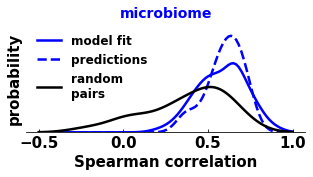

In [44]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(profile)
x = np.linspace(np.min(profile+[-0.5]), np.max(profile+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x),color='b',linewidth=2.5, label='model fit')

kde=stats.gaussian_kde(pred_profile)
x = np.linspace(np.min(pred_profile+[-0.5]), np.max(pred_profile+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='b',linewidth=2.5,linestyle='--', label='predictions')

kde=stats.gaussian_kde(random)
x = np.linspace(np.min(random+[-0.5]), np.max(random+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,4)
ax.set_title('microbiome', fontweight='bold', fontsize=14, color='b')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False)
ax.set_xticks([-0.5,0, 0.5,1])
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15,direction='in')
plt.xticks(weight = 'bold');

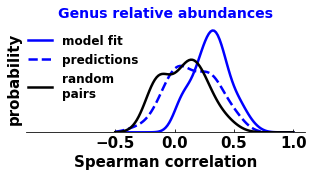

In [45]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(otuprofile)
x = np.linspace(np.min(otuprofile+[-0.5]), np.max(otuprofile+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x),color='b',linewidth=2.5, label='model fit')

kde=stats.gaussian_kde(pred_otuprofile)
x = np.linspace(np.min(pred_otuprofile+[-0.5]), np.max(pred_otuprofile+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='b',linewidth=2.5,linestyle='--', label='predictions')

kde=stats.gaussian_kde(randomotu)
x = np.linspace(np.min(randomotu+[-0.5]), np.max(randomotu+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,2.7)
ax.set_xlim(-1.25,1.1)
ax.set_title('Genus relative abundances', fontweight='bold', fontsize=14, color='b')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(0.44,1))
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15,direction='in')
plt.xticks(weight = 'bold');

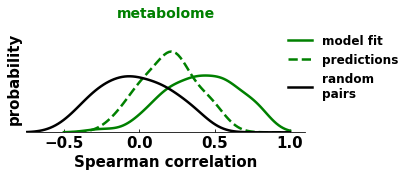

In [46]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(metprofile)
#kde.set_bandwidth(0.5)
x = np.linspace(np.min(metprofile+[-0.5]), np.max(metprofile+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x),color='g',linewidth=2.5, label='model fit')

kde=stats.gaussian_kde(pred_metprofile)
x = np.linspace(np.min(pred_metprofile+[-0.5]), np.max(pred_metprofile+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='g',linewidth=2.5,linestyle='--', label='predictions')

kde=stats.gaussian_kde(randommet)
x = np.linspace(np.min(randommet+[-0.75]), np.max(randommet+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,2.7)
ax.set_xlim(-0.75,1.1)
ax.set_title('metabolome', fontweight='bold', fontsize=14, color='g')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(0.9,1))
ax.set_xticks([-0.5,0, 0.5,1])
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15, direction='in')
plt.xticks(weight = 'bold');

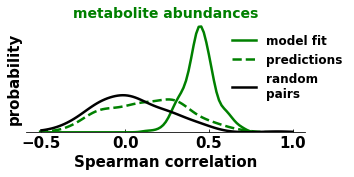

In [47]:
#histograms
fig,ax=plt.subplots(figsize=(5,2))

kde=stats.gaussian_kde(metcorr)
x = np.linspace(np.min(metcorr+[-0.5]), np.max(metcorr+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x),color='g',linewidth=2.5, label='model fit')

kde=stats.gaussian_kde(pred_metcorr)
x = np.linspace(np.min(pred_metcorr+[-0.5]), np.max(pred_metcorr+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='g',linewidth=2.5,linestyle='--', label='predictions')

kde=stats.gaussian_kde(randommetcorr)
x = np.linspace(np.min(randommetcorr+[-0.5]), np.max(randommetcorr+[1]), 100)
ax=sns.lineplot(x=x, y=kde(x), color='k',linewidth=2.5, label='random\npairs')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('probability', fontsize=15,fontweight='bold')
ax.set_xlabel('Spearman correlation', fontsize=15,fontweight='bold')
ax.set_ylim(0,5)
ax.set_title('metabolite abundances', fontweight='bold', fontsize=14, color='g')
legend_properties = {'weight':'bold','size':12}
ax.legend(prop=legend_properties,frameon=False, bbox_to_anchor=(0.7,1))
ax.set_xticks([-0.5,0, 0.5,1])
ax.set_xticks([-0.5,0, 0.5,1])
ax.tick_params(axis='x', which='major', labelsize=15,direction='in')
plt.xticks(weight = 'bold');